In [1]:
import cv2,os
import math
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict

import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from torch.nn import functional as F
from Scripts.utils import ellipse, rectangle, rotate, ZeroPaddingResizeCV
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)", flush=True)
    print("torch.cuda.device_count(): ", torch.cuda.device_count(), flush=True)
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(), flush=True)
    print("torch.cuda.current_device()", torch.cuda.current_device(), flush=True)
else:
    device = torch.device("cpu")
    print("torch.device(cpu)", flush=True)

/home/acd13264yb/python10_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/acd13264yb/python10_env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 0.0 CAM
* this code is used by: https://github.com/jacobgil/pytorch-grad-cam
* Example: https://colab.research.google.com/drive/1UKcvOL_5sdDPJKU69MiADp8Y1-e24vz9?usp=sharing#scrollTo=AlrrU_yW9ZCX

In [2]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image
from torchvision.models import resnet50

def predict(model,input_tensor,true_y):
    model.eval()
    output = model(input_tensor)
    pre_y = output.argmax(1).cpu().item()
    return pre_y==true_y, pre_y

def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor, targets)[0]
    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=False)
    
#     # Guided-GradCAM
#     gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
#     gb = gb_model(input_tensor, targets)
#     if np.amax(gb)!=0:
#         gb = np.maximum(gb,0)*(1/np.amax(gb))
#     cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
#     cam_gb = cam_mask * gb
    
    return visualization, grayscale_cam

# 0. Load Data and Model

In [13]:
stain_type="CTCF"
model_type="Resnet10_noavg"
rett_type="HPS3042"

In [14]:
X_Ctrl = np.load(f"./Datasets/CTRL_{stain_type}.npy",allow_pickle=True)[:100]
X_Rett = np.load(f"./Datasets/RETT_{rett_type}_{stain_type}.npy",allow_pickle=True)[:100]
chip_li = ["All", "H3K27ac", "CTCF", "Dapi"]

In [15]:
# rett_type="HPS9999"
weight_path = f"./results/{rett_type}_{stain_type}_{model_type}/{rett_type}_{stain_type}_{model_type}_Fold0.pkl"
weight = torch.load(weight_path)
print(weight_path)
if model_type=="Resnet10_noavg":
    from models.Resnet10_noavg import MyModel
elif model_type=="Resnet10_noavg":
    from models.Resnet10 import MyModel
elif model_type=="Resnet18":
    from models.Resnet18 import MyModel
elif model_type=="HRUnet":
    from models.HRUnet import MyModel
    
model = MyModel().to(device)
model.resnet.load_state_dict(weight)

./results/HPS3042_CTCF_Resnet10_noavg/HPS3042_CTCF_Resnet10_noavg_Fold0.pkl


<All keys matched successfully>

In [16]:
model.resnet.layer2[1]

BasicBlock(
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

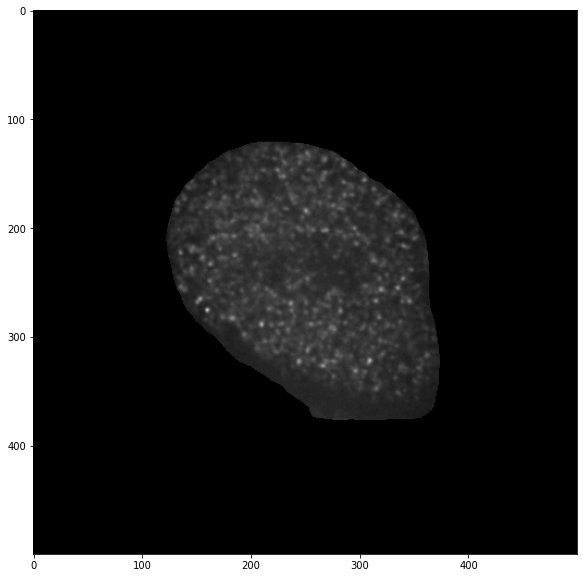

torch.Size([1, 3, 500, 500])
torch.Size([1, 2])


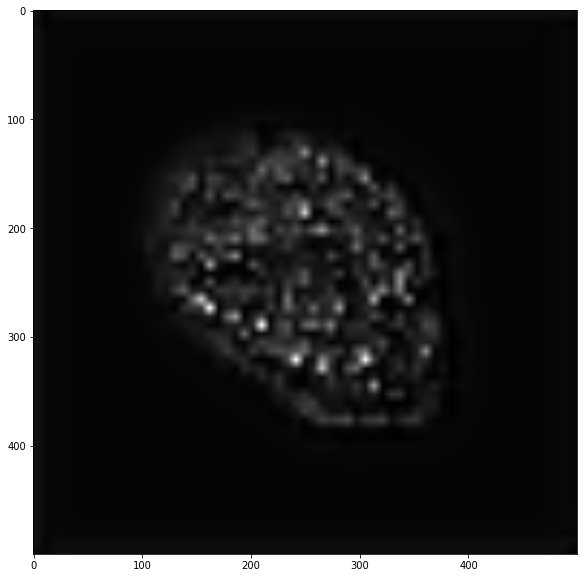

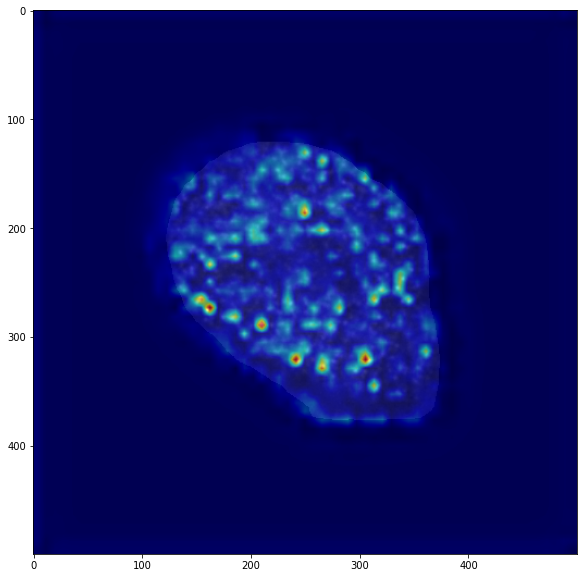

In [18]:
img = X_Rett[10]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = np.float32(img)/255
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to(device)
print(input_tensor.size())

output = model(input_tensor)
print(output.shape)


target_layers = [model.resnet.layer2]
optioncam = "ScoreCAM"
visualization,cam = gradcams(model,input_tensor,target_layers,img,optioncam)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cam, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
plt.show()

# 1. GradCAM heatmap in samples 

## 1.0 abstract

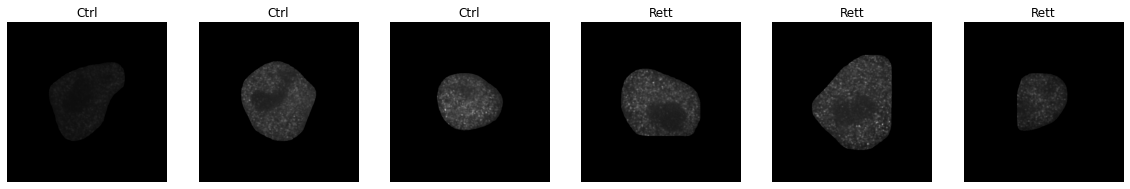

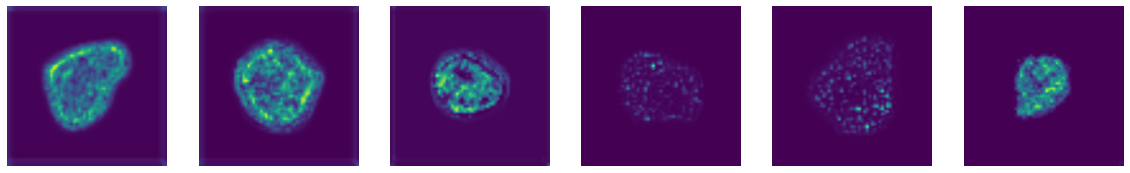

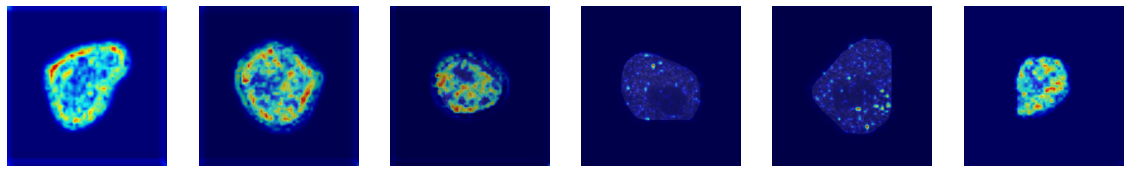

In [19]:
def title(label):
    if label==0:
        return "Ctrl"
    else:
        return "Rett"
Visual_sample = []
index = [0,1,2]
for i in index:
    img = X_Ctrl[i]
    Visual_sample.append(img)
index = [0,1,2]
for i in index:
    img = X_Rett[i]
    Visual_sample.append(img)

Visual_sample = np.array(Visual_sample)
y_Visual_sample = torch.tensor([0,0,0,1,1,1], dtype=torch.int64)
plt.figure(figsize=(20,20))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.title(title(y_Visual_sample[i]))
    plt.axis("off")
    plt.imshow(Visual_sample[i])
    
plt.figure(figsize=(20,20))
for n in range(6):
    img = Visual_sample[n]
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,y_Visual_sample[n])
    visualization,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    plt.subplot(1,6,n+1)
    plt.axis("off")
    plt.imshow(cam)

plt.figure(figsize=(20,20))
for n in range(6):
    img = Visual_sample[n]
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,y_Visual_sample[n])
    visualization,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    plt.subplot(1,6,n+1)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))

## 1.1 samples of CTRL

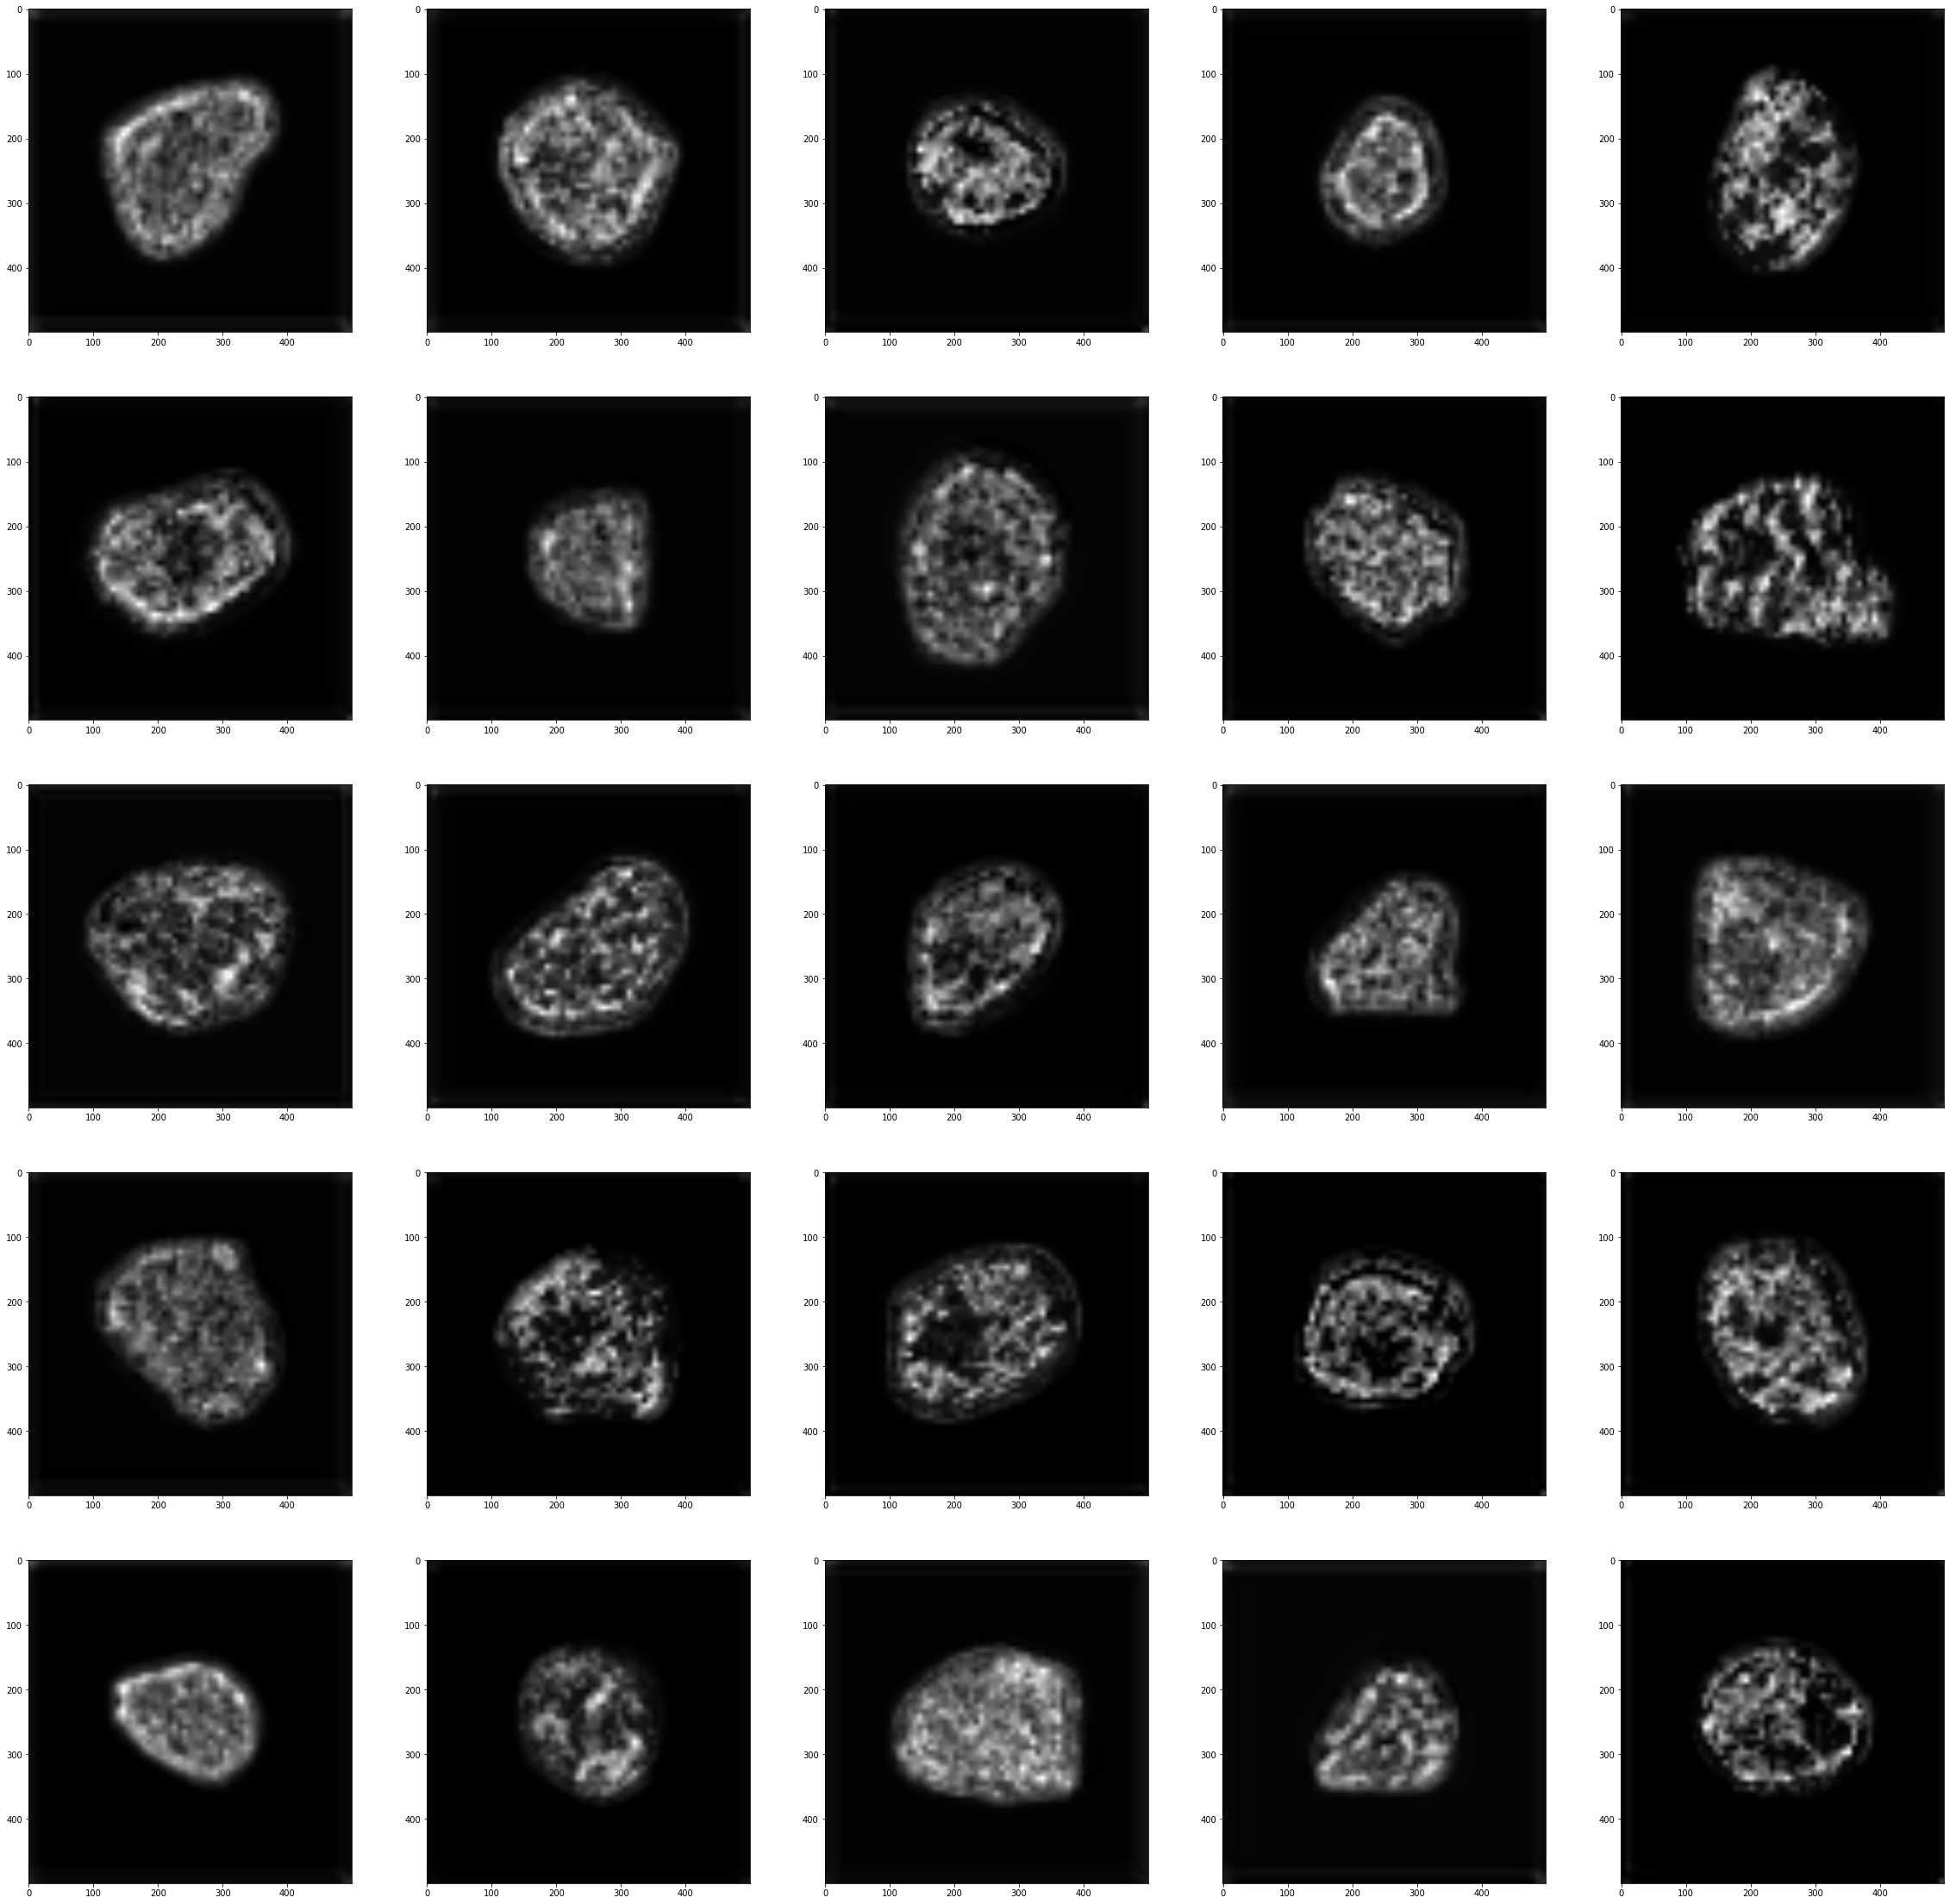

In [23]:
true_y = 0
times=0
fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in range(25):
    img = X_Ctrl[n]
    result, angle = ellipse(img)
    x, y, w, h = rectangle(result)
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf, pred = predict(model,input_tensor,true_y)
    visualization,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    heatmap = ZeroPaddingResizeCV(rotate(cam, angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
    plt.subplot(5,5,n+1)
#     plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
    plt.imshow(cam)

## 1.2 samples of RETT

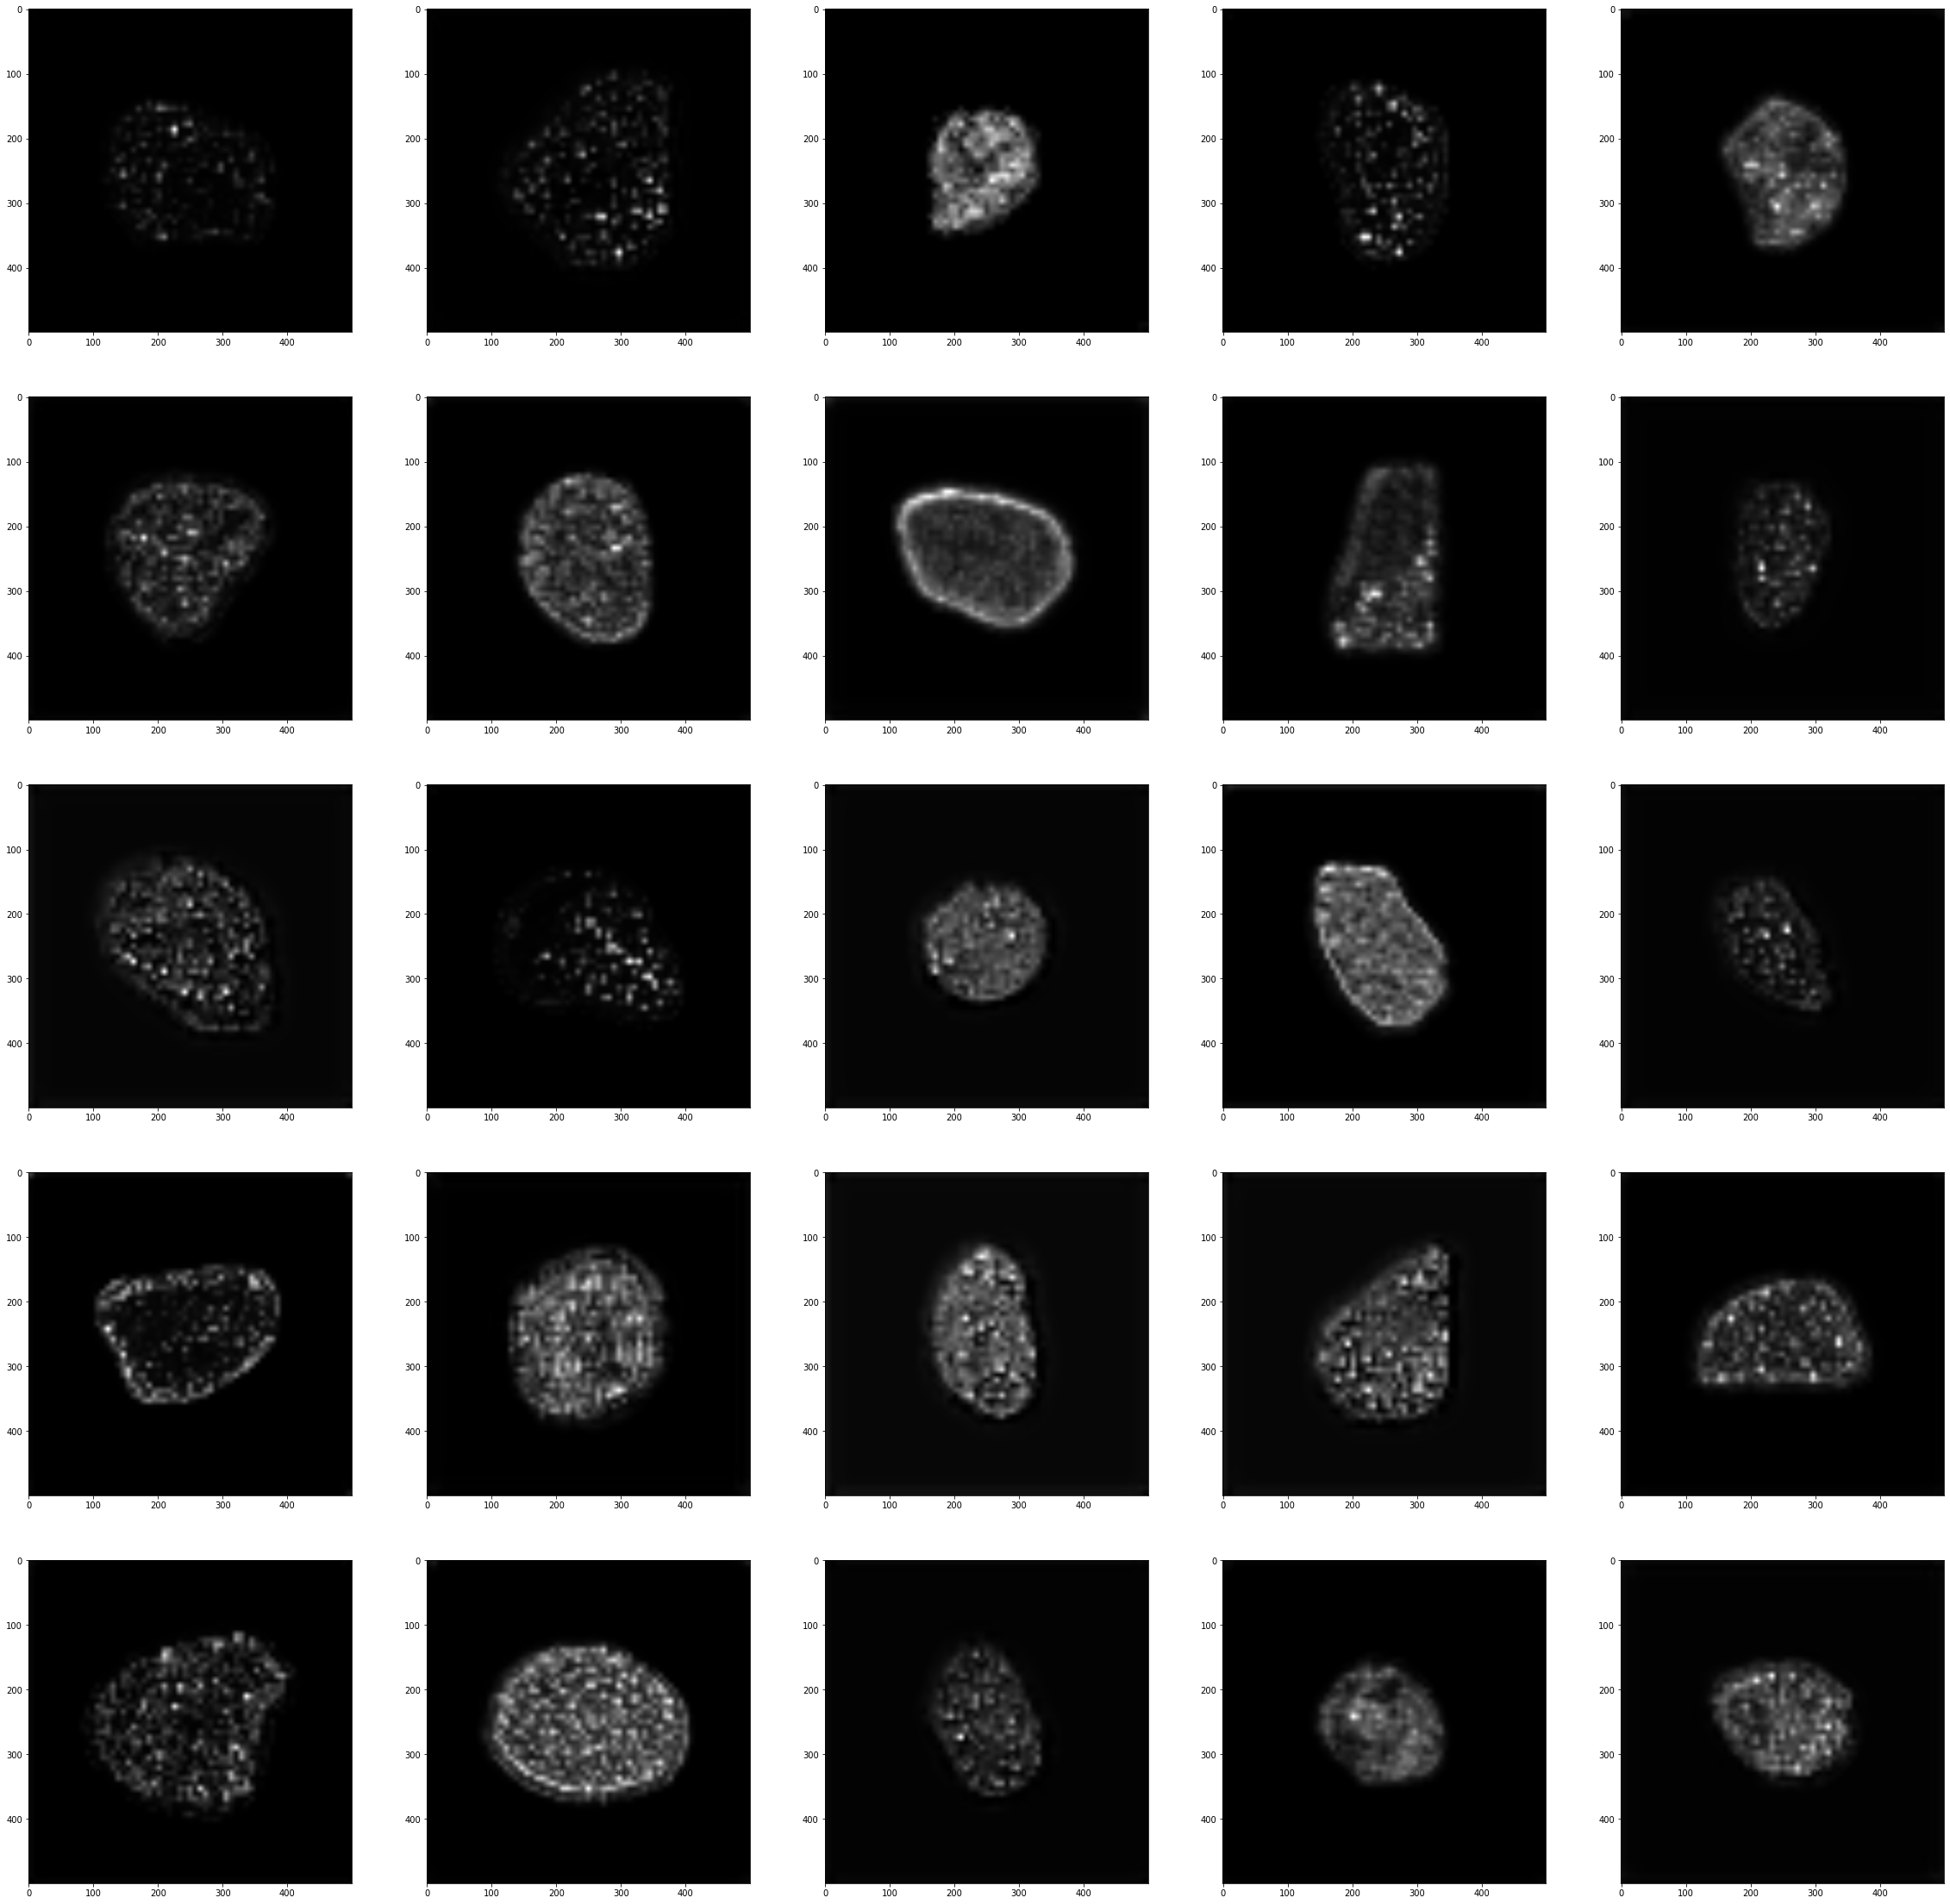

In [26]:
true_y = 1
fig, ax = plt.subplots(5,5, figsize = (40,40))
times=0
for n in range(25):
    img = X_Rett[n]
    result, angle = ellipse(img)
    x, y, w, h = rectangle(result)
    img = np.float32(img)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    visualization,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    heatmap = ZeroPaddingResizeCV(rotate(cam, angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
    plt.subplot(5,5,n+1)
#     plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
    plt.imshow(cam)

# 2. Guided-GradCAM in samples

## 2.1 Gb samples of untreated

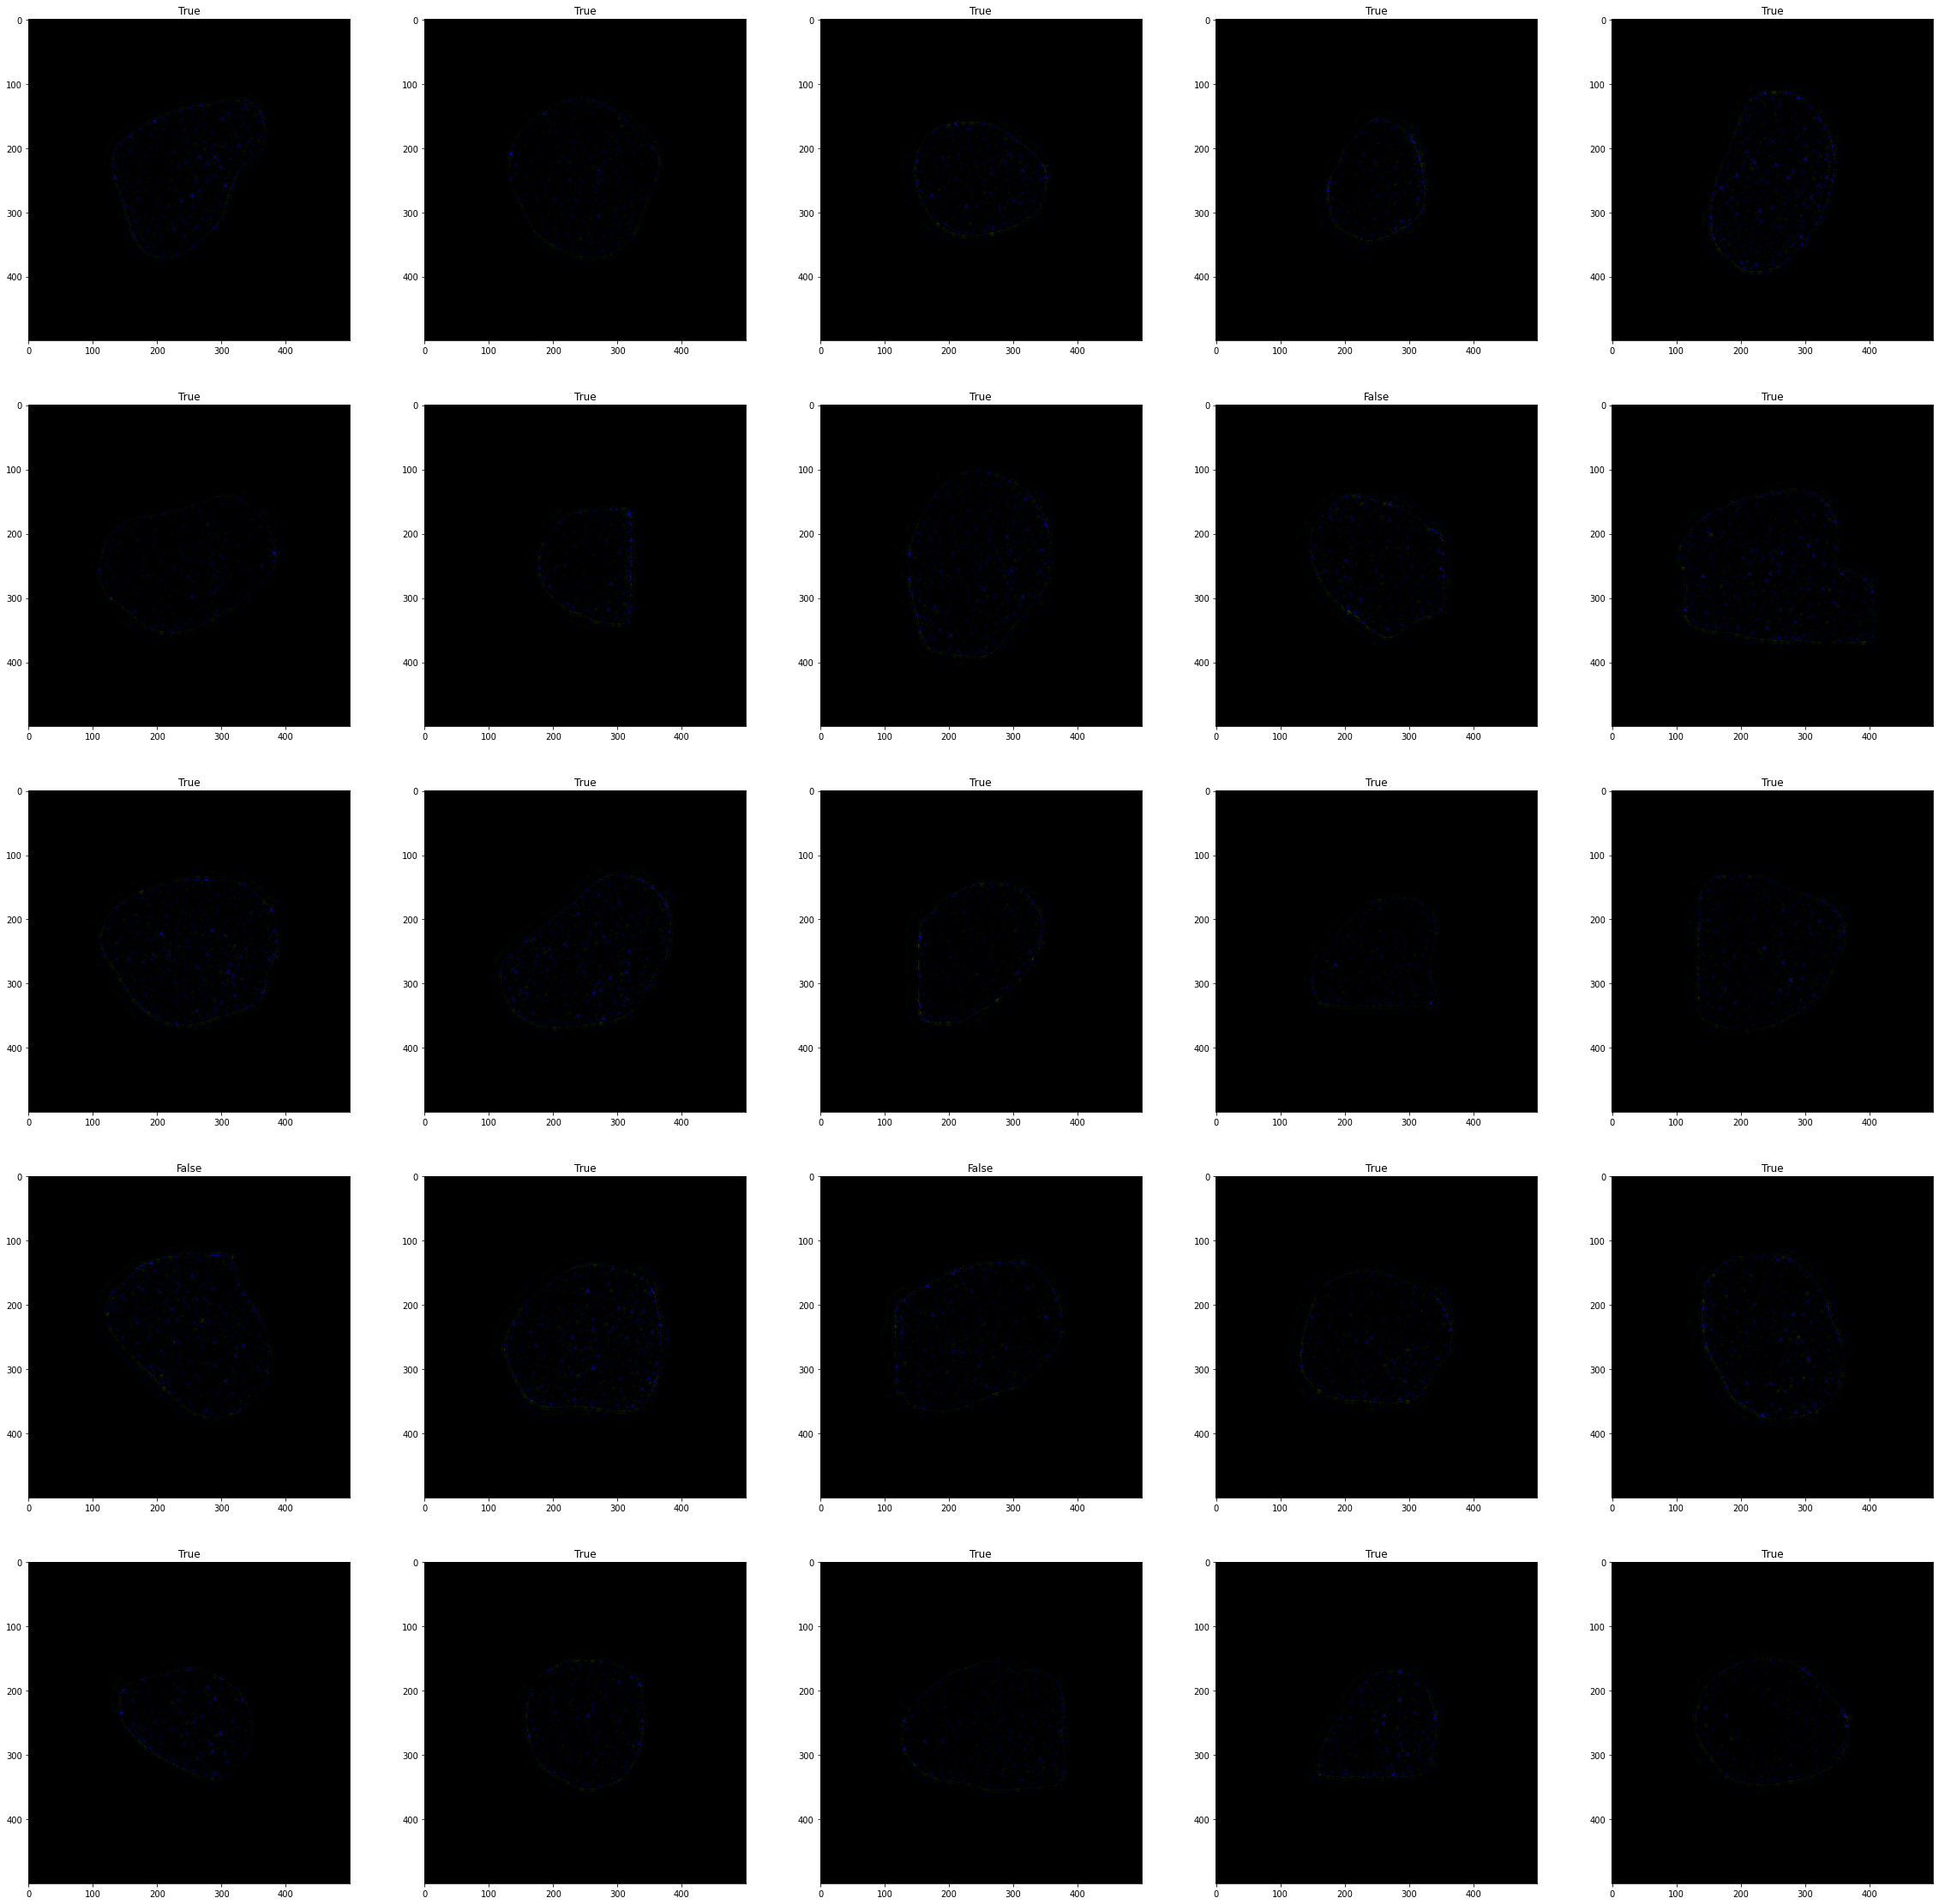

In [43]:
true_y = 0
fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in range(25):
    img = X_Ctrl[n]
    img = np.float32(img)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)

    plt.subplot(5,5,n+1)
    plt.title(tf)
    plt.imshow(cv2.cvtColor(gb, cv2.COLOR_BGR2RGB))

## 2.2 Gb samples of RETT

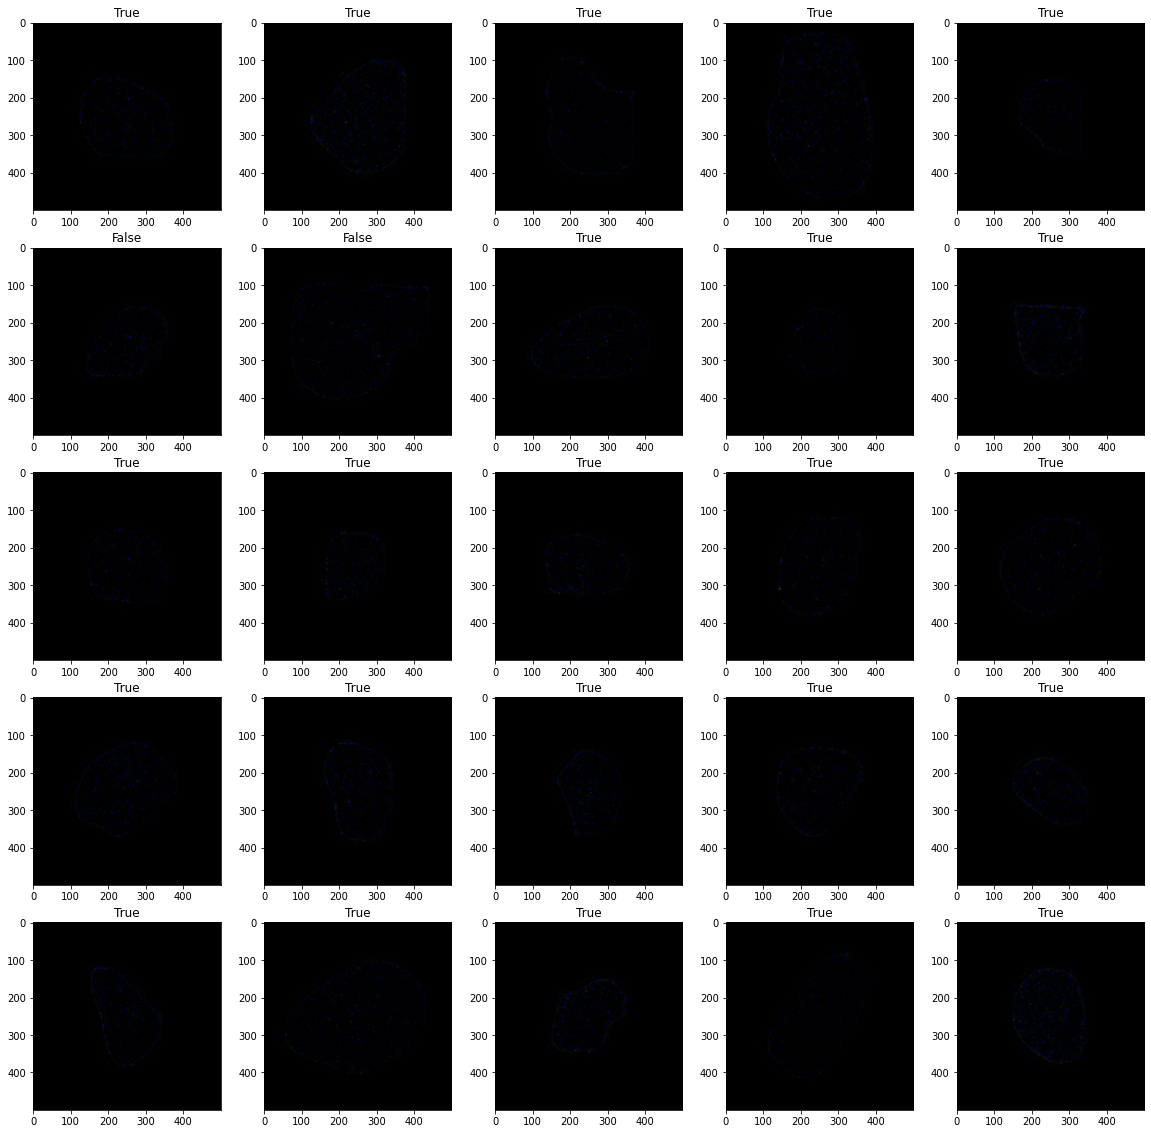

In [44]:
true_y = 1
fig, ax = plt.subplots(5,5, figsize = (20,20))
for n in range(25):
        img=X_Rett[n]
        img = np.float32(img)/255

        transform = transforms.Compose([transforms.ToTensor()])
        input_tensor = transform(img).unsqueeze(0).to(device)

        tf,pred = predict(model,input_tensor,true_y)
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
        
        plt.subplot(5,5,n+1)
        plt.title(tf)
        plt.imshow(cv2.cvtColor(gb, cv2.COLOR_BGR2RGB))

# 3. Average of GradCAM heatmap

## 3.0 processing function

In [22]:
def ellipse(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0 , 255, cv2.THRESH_BINARY)[1]
    contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)
    ellipse = cv2.fitEllipse(big_contour)
    (xc,yc),(d1,d2),angle = ellipse
    result = img.copy()
    cv2.ellipse(result, ellipse, (0, 255, 0), 3)
    xc, yc = ellipse[0]
    cv2.circle(result, (int(xc),int(yc)), 10, (255, 255, 255), -1)
    rmajor = max(d1,d2)/2
    if angle > 90:
        angle = angle - 90
    else:
        angle = angle + 90
    xtop = xc + math.cos(math.radians(angle))*rmajor
    ytop = yc + math.sin(math.radians(angle))*rmajor
    xbot = xc + math.cos(math.radians(angle+180))*rmajor
    ybot = yc + math.sin(math.radians(angle+180))*rmajor
    cv2.line(result, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 0, 255), 3)
    return result, angle

In [23]:
def rectangle(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0 , 255, cv2.THRESH_BINARY)[1]
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x, y, w, h = cv2.boundingRect(cnt)
    return x, y, w, h

In [24]:
def rotate(img, angle):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    rotated = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(img, rotated, (w, h))
    return rotated

In [25]:
def ZeroPaddingResizeCV(img, size=(600, 600), interpolation=None, n=3):
    isize = img.shape
    ih, iw = isize[0], isize[1]
    h, w = size[0], size[1]
    scale = min(w / iw, h / ih)
    new_w = int(iw * scale + 0.5)
    new_h = int(ih * scale + 0.5)
 
    img = cv2.resize(img, (new_w, new_h), interpolation)
    if n==3:
        new_img = np.zeros((h, w, n), np.uint8)
        new_img[(h-new_h)//2:(h+new_h)//2, (w-new_w)//2:(w+new_w)//2] = img
    else:
        new_img = np.zeros((h, w), np.float32)
        new_img[(h-new_h)//2:(h+new_h)//2, (w-new_w)//2:(w+new_w)//2] = img
    return new_img

In [22]:
# X = [X_Ctrl[1],X_Ctrl[3],X_Ctrl[7],X_Ctrl[11],X_Ctrl[16],X_Ctrl[19]]
X = [X_VPA[1],X_VPA[3],X_VPA[7],X_VPA[11],X_VPA[16],X_VPA[19]]

In [24]:
# plt.figure(figsize=(20,20))
# for n in range(6):
#     img = np.zeros([600,600,3],dtype=np.uint8)
#     img[:,:,0] = X[n][:,:,0]
#     plt.imshow(img)
#     cv2.imwrite("figures/Fig3.c.original.tif",img)
    
# plt.figure(figsize=(20,20))
# for n in range(6):
#     img = np.zeros([600,600,3],dtype=np.uint8)
#     img[:,:,0] = X[n][:,:,0]
#     result, angle = ellipse(img)
#     plt.subplot(1,6,n+1)
#     plt.title("angle: {:1f}".format(angle))
#     plt.imshow(result)
#     cv2.imwrite("figures/Fig_S3.b.angle.tif",result)

# plt.figure(figsize=(20,20))
# for n in range(6):
#     img = np.zeros([600,600,3],dtype=np.uint8)
#     img[:,:,0] = X[n][:,:,0]
#     result, angle = ellipse(img)
#     result = rotate(result, angle-45)
#     plt.subplot(1,6,n+1)
#     plt.title("angle: 45")
#     plt.imshow(result)
#     cv2.imwrite("figures/Fig_S3.c.rotate.tif",result)
    
# plt.figure(figsize=(20,20))
# for n in range(6):
#     img = np.zeros([600,600,3],dtype=np.uint8)
#     img[:,:,0] = X[n][:,:,0]
#     result, angle = ellipse(img)
#     result = rotate(result, angle-45)
#     x, y, w, h = rectangle(result)
#     result = result[y:y+h,x:x+w]
#     result = ZeroPaddingResizeCV(result, size=(600, 600))
#     plt.subplot(1,6,n+1)
#     plt.title("zoomed and rotated")
#     plt.imshow(result)
#     cv2.imwrite("figures/Fig_S3.d.zoom.tif",result)

In [47]:
# n = 7
# cam = pltcam(X_RETT[n], 1, chip_li[1])

# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 0 , 1, cv2.THRESH_BINARY)[1]
# mask = thresh.copy()
# h, w = thresh.shape[:2]
# scale = 0.95
# new_h, new_w = int(h * scale), int(w * scale)
# pad = (h - new_h) // 2
# resized = cv2.resize(cam, (new_w, new_h))
# cam_pad = cv2.copyMakeBorder(resized, top=pad, bottom=pad, left=pad, right=pad, borderType=cv2.BORDER_CONSTANT, value=[0,0,0])

# cam_pad*=thresh
# plt.axis("off")
# plt.imshow(cam_pad)
# plt.show()
# print(cam_pad.shape)

# plt.imshow(cam_pad)
# plt.axis("off")
# plt.show()
# cv2.imwrite("figures/Fig3.b.cam.tif",cam_pad)

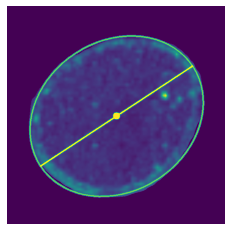

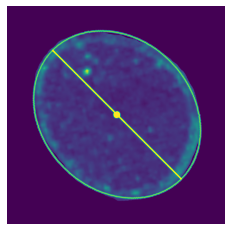

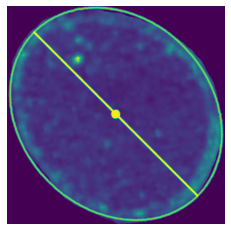

True

In [95]:
n = 7
img = X_VPA[n]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0 , 255, cv2.THRESH_BINARY)[1]
contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)
ellipse = cv2.fitEllipse(big_contour)
(xc,yc),(d1,d2),angle = ellipse

result = cam_pad.copy()*255
cv2.ellipse(result, ellipse, 200, 3)
xc, yc = ellipse[0]
cv2.circle(result, (int(xc),int(yc)), 10, 255, -1)
rmajor = max(d1,d2)/2
if angle > 90:
    angle = angle - 90
else:
    angle = angle + 90
xtop = xc + math.cos(math.radians(angle))*rmajor
ytop = yc + math.sin(math.radians(angle))*rmajor
xbot = xc + math.cos(math.radians(angle+180))*rmajor
ybot = yc + math.sin(math.radians(angle+180))*rmajor
cv2.line(result, (int(xtop),int(ytop)), (int(xbot),int(ybot)), 255, 3)
plt.axis("off")
plt.imshow(result)
plt.show()
cv2.imwrite("figures/Fig3.b.cam_ellipse.png",result)

result = rotate(result, angle-45)
plt.axis("off")
plt.imshow(result)
plt.show()
cv2.imwrite("figures/Fig3.b.cam_rotate.png",result)

result = ZeroPaddingResizeCV(result[y:y+h,x:x+w], size=(600, 600),n=1)
plt.axis("off")
plt.imshow(result)
plt.show()
cv2.imwrite("figures/Fig3.b.cam_zoom.png",result)

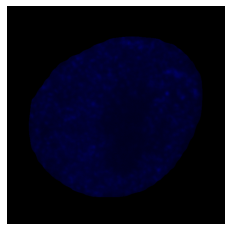

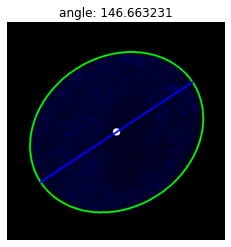

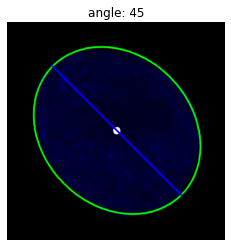

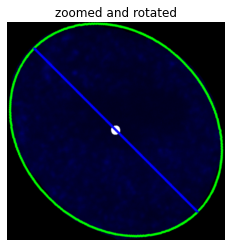

True

In [92]:
# plt.figure(figsize=(20,20))
n = 7
img = np.zeros([600,600,3],dtype=np.uint8)
img[:,:,2] = X_VPA[n][:,:,0]
plt.imshow(img)
plt.axis("off")
plt.show()
cv2.imwrite("figures/Fig3.b.original.tif",img)

img = np.zeros([600,600,3],dtype=np.uint8)
img[:,:,2] = X_VPA[n][:,:,0]
result, angle = ellipse(img)
plt.title("angle: {:1f}".format(angle))
plt.imshow(result)
plt.axis("off")
plt.show()
cv2.imwrite("figures/Fig3.b.angle.tif",result)

img = np.zeros([600,600,3],dtype=np.uint8)
img[:,:,2] = X_VPA[n][:,:,0]
result, angle = ellipse(img)
result = rotate(result, angle-45)
plt.title("angle: 45")
plt.imshow(result)
plt.axis("off")
plt.show()
cv2.imwrite("figures/Fig3.b.rotate.tif",result)
    
img = np.zeros([600,600,3],dtype=np.uint8)
img[:,:,2] = X_VPA[n][:,:,0]
result, angle = ellipse(img)
result = rotate(result, angle-45)
x, y, w, h = rectangle(result)
result = result[y:y+h,x:x+w]
result = ZeroPaddingResizeCV(result, size=(600, 600))
plt.title("zoomed and rotated")
plt.imshow(result)
plt.axis("off")
plt.show()
cv2.imwrite("figures/Fig3.b.zoom.tif",result)

In [12]:
# img = X_Ctrl[n]
# result, angle = ellipse(img)
# x, y, w, h = rectangle(result)
# img = np.float32(img)/255
# transform = transforms.Compose([transforms.ToTensor()])
# input_tensor = transform(img).unsqueeze(0).to(device)
# tf,pred = predict(model,input_tensor,true_y)
# visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer2[1].conv2],img,optioncam)
# plt.figure(figsize=(10,10))
# plt.subplot(1,4,1)
# plt.imshow(img)
# plt.subplot(1,4,2)
# plt.imshow(rotate(result, angle-45))
# plt.subplot(1,4,3)
# plt.imshow(rotate(result, angle-45)[y:y+h,x:x+w])
# plt.subplot(1,4,3)
# plt.imshow(rotate(result, angle-45)[y:y+h,x:x+w])
# plt.subplot(1,4,4)
# plt.imshow(ZeroPaddingResizeCV(rotate(result, angle-45)[y:y+h,x:x+w], size=(600, 600)))

# plt.figure(figsize=(10,10))
# plt.subplot(1,4,1)
# plt.imshow(cam[:,:,0])
# plt.subplot(1,4,2)
# plt.imshow(rotate(cam[:,:,0], angle-45))
# plt.subplot(1,4,3)
# plt.imshow(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w])
# plt.subplot(1,4,4)
# plt.imshow(ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1))

In [75]:
optioncam = "GradCAM"
# optioncam = "ScoreCAM"

## 3.1 average in untreated

In [88]:
true_y = 0
count = 0
intensity00_conv1 = []
intensity00_layer1 = []
intensity00_layer2 = []
intensity00_layer3 = []
intensity00_layer4 = []
intensity00_gb = []
total = 10

for n in tqdm(range(total)):
    img = X_Ctrl[n]
    result, angle = ellipse(img)
    x, y, w, h = rectangle(result)
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.conv1],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity00_conv1.append(heatmap)
        
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer1],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity00_layer1.append(heatmap)
        
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer2],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity00_layer2.append(heatmap)

#         visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer3[1].conv2],img,optioncam)
#         intensity00_layer3+=ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer4[1].conv2],img,optioncam)
#         intensity00_layer4+=ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
        heatmap = ZeroPaddingResizeCV(rotate(gb[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity00_gb.append(heatmap)

        count+=1
intensity00_conv1 = np.array(intensity00_conv1)
intensity00_layer1 = np.array(intensity00_layer1)
intensity00_layer2 = np.array(intensity00_layer2)
intensity00_gb = np.array(intensity00_gb)
print("intensity00_layer2.shape: ", intensity00_layer2.shape)
print("Data00 acc: {:.3f}, count: {:}, total: {:} " .format(count/total,count,total))

100%|██████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]

intensity00_layer2.shape:  (10, 600, 600)
Data00 acc: 1.000, count: 10, total: 10 


In [ ]:

plt.figure(figsize=(20,20))
plt.subplot(1,6,1)
plt.title(intensity00_conv1.max())
plt.imshow(intensity00_conv1)
plt.subplot(1,6,2)
plt.title(intensity00_layer1.max())
plt.imshow(intensity00_layer1)
plt.subplot(1,6,3)
plt.title(intensity00_layer2.max())
plt.imshow(intensity00_layer2)
plt.subplot(1,6,4)
plt.title(intensity00_gb.max())
# plt.imshow(intensity00_layer3)
# plt.subplot(1,6,5)
# plt.imshow(intensity00_layer4)
# plt.subplot(1,6,6)
plt.imshow(intensity00_gb)

## 3.2 average in VPA

In [ ]:
true_y = 1
count = 0
intensity01_conv1 = np.zeros((600,600))
intensity01_layer1 = np.zeros((600,600))
intensity01_layer2 = np.zeros((600,600))
intensity01_layer3 = np.zeros((600,600))
intensity01_layer4 = np.zeros((600,600))
intensity01_gb = np.zeros((600,600))
total = 3000

for n in tqdm(range(total)):
    img = X_VPA[n]
    result, angle = ellipse(img)
    x, y, w, h = rectangle(result)
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.conv1],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity01_conv1+=heatmap

        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer1],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity01_layer1+=heatmap
        
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer2],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity01_layer2+=heatmap
        
#         visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer3[1].conv2],img,optioncam)
#         intensity01_layer3+=ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer4[1].conv2],img,optioncam)
#         intensity01_layer4+=ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)

        heatmap = ZeroPaddingResizeCV(rotate(gb[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity01_gb+=heatmap
        count+=1
print("Data01 acc: {:.3f}, count: {:}, total: {:} " .format(count/total,count,total))

In [ ]:
intensity01_conv1 = intensity01_conv1/(count)
intensity01_layer1 = intensity01_layer1/(count)
intensity01_layer2 = intensity01_layer2/(count)
# intensity01_layer3 = intensity01_layer3/(count*np.amax(intensity01_layer3))
# intensity01_layer4 = intensity01_layer4/(count*np.amax(intensity01_layer4))
intensity01_gb = intensity01_gb/(count)
plt.figure(figsize=(20,20))
plt.subplot(1,6,1)
plt.title(intensity01_conv1.max())
plt.imshow(intensity01_conv1)
plt.subplot(1,6,2)
plt.title(intensity01_layer1.max())
plt.imshow(intensity01_layer1)
plt.subplot(1,6,3)
plt.title(intensity01_layer2.max())
plt.imshow(intensity01_layer2)
plt.subplot(1,6,4)
plt.title(intensity01_gb.max())
# plt.imshow(intensity01_layer3)
# plt.subplot(1,6,5)
# plt.imshow(intensity01_layer4)
# plt.subplot(1,6,6)
plt.imshow(intensity01_gb)

In [ ]:
zero_x = np.zeros((100,600))
zero_y = np.zeros((1300,100))
plt.figure(figsize=(10,10))
conv1 = np.concatenate([intensity00_conv1,zero_x,intensity01_conv1],axis=0)
layer1 = np.concatenate([intensity00_layer1,zero_x,intensity01_layer1],axis=0)
layer2 = np.concatenate([intensity00_layer2,zero_x,intensity01_layer2],axis=0)
gb = np.concatenate([intensity00_gb,zero_x,intensity01_gb],axis=0)
# plt.axis('off')
# plt.imshow(np.concatenate([conv1,zero_y,layer1,zero_y,layer2,zero_y,gb],axis=1))
plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(conv1/conv1.max())
plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(layer1/layer1.max())
plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(layer2/layer2.max())
plt.subplot(1,4,4)
plt.axis('off')
plt.imshow(gb/gb.max())

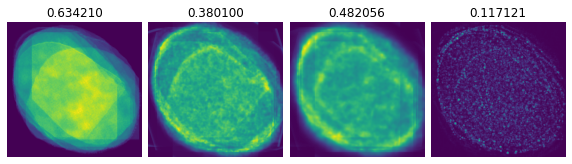

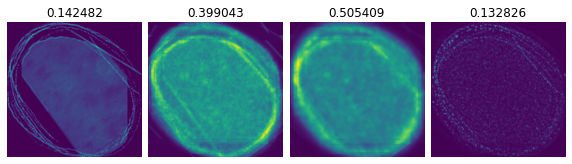

In [60]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.subplot(2,4,1)
plt.axis('off')
plt.title("{:.6f}".format(intensity00_conv1.max()))
plt.imshow(intensity00_conv1)
plt.subplot(2,4,2)
plt.axis('off')
plt.title("{:.6f}".format(intensity00_layer1.max()))
plt.imshow(intensity00_layer1)
plt.subplot(2,4,3)
plt.axis('off')
plt.title("{:.6f}".format(intensity00_layer2.max()))
plt.imshow(intensity00_layer2)
plt.subplot(2,4,4)
plt.axis('off')
plt.title("{:.6f}".format(intensity00_gb.max()))
plt.imshow(intensity00_gb)

plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.subplot(2,4,5)
plt.axis('off')
plt.title("{:.6f}".format(intensity01_conv1.max()))
plt.imshow(intensity01_conv1)
plt.subplot(2,4,6)
plt.axis('off')
plt.title("{:.6f}".format(intensity01_layer1.max()))
plt.imshow(intensity01_layer1)
plt.subplot(2,4,7)
plt.axis('off')
plt.title("{:.6f}".format(intensity01_layer2.max()))
plt.imshow(intensity01_layer2)
plt.subplot(2,4,8)
plt.axis('off')
plt.title("{:.6f}".format(intensity01_gb.max()))
plt.imshow(intensity01_gb)

## 3.1 Use CAM mask results as input image, predict by the same CNN

In [20]:
true_y = 0
img = X_VPA[0]
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to(device)
tf,pred = predict(model,input_tensor,true_y)

img = np.float32(img)/255
img = img/np.amax(img)
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)

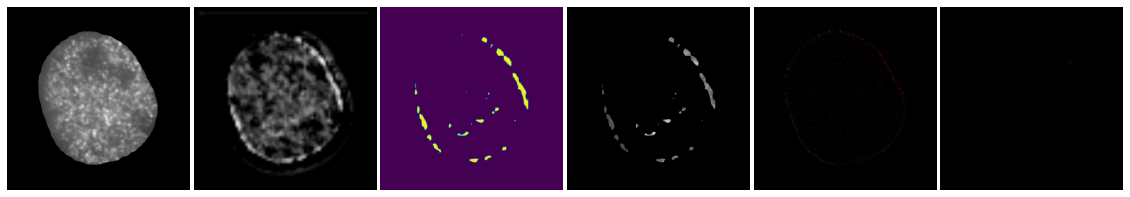

In [21]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.subplot(1,6,1)
plt.axis("off")
plt.imshow(img)
plt.subplot(1,6,2)
plt.axis("off")
plt.imshow(cam)
mask = transform(cam)[0].ge(0.5).numpy()
plt.subplot(1,6,3)
plt.axis("off")
plt.imshow(mask)
camcell = np.multiply(mask,img[:,:,0])
camcell = cv2.merge([camcell,camcell,camcell])
plt.subplot(1,6,4)
plt.axis("off")
plt.imshow(camcell)
plt.subplot(1,6,5)
plt.axis("off")
plt.imshow(gb)
plt.subplot(1,6,6)
plt.axis("off")
plt.imshow(cam_gb)

In [53]:
total = 3000
count = 0
true_y = 0
thre = 0.6
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_00[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        mask = transform(cam)[0].ge(thre).numpy()
        camcell = np.multiply(mask,img[:,:,0])
        camcell = cv2.merge([camcell,camcell,camcell])
        input_tensor = transform(camcell).unsqueeze(0).to(device)
        tf,pred = predict(model,input_tensor,true_y)
        if tf == True:
            count+=1
print("cam mask cell_00 accuracy is ", count/total)

100%|█████████████████████████████████████████████████████████| 3000/3000 [00:50<00:00, 59.85it/s]

cam mask cell_00 accuracy is  0.975


In [54]:
total = 3000
count = 0
true_y = 1
thre = 0.6
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        mask = transform(cam)[0].ge(thre).numpy()
        camcell = np.multiply(mask,img[:,:,0])
        camcell = cv2.merge([camcell,camcell,camcell])
        input_tensor = transform(camcell).unsqueeze(0).to(device)
        tf,pred = predict(model,input_tensor,true_y)
        if tf == True:
            count+=1
print("cam mask cell_01Nami accuracy is ", count/total)

100%|█████████████████████████████████████████████████████████| 3000/3000 [00:49<00:00, 60.25it/s]

cam mask cell_01Nami accuracy is  0.10133333333333333


## 3.2 Use gb results as input image, predict by the same CNN

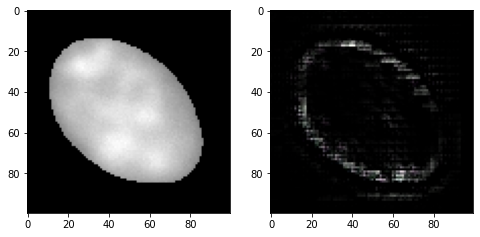

In [55]:
true_y = 0
img = Data_00[1]
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to(device)
tf,pred = predict(model,input_tensor,true_y)
img = np.float32(img)/255
img = img/np.amax(img)
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
if tf == True:
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(gb)

In [29]:
total = 3000
count = 0
true_y = 0
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_00[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        input_tensor = transform(gb).unsqueeze(0).to(device)
        tf_gb,pred_gb = predict(model,input_tensor,true_y)
        if tf_gb == True:
            count+=1
print("gb 00 accuracy is ", count/total)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:47<00:00, 63.59it/s]

gb 00 accuracy is  0.7226666666666667


In [30]:
total = 3000
count = 0
true_y = 1
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        input_tensor = transform(gb).unsqueeze(0).to(device)
        tf_gb,pred_gb = predict(model,input_tensor,true_y)
        if tf_gb == True:
            count+=1
print("gb 01 accuracy is ", count/total)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:47<00:00, 63.68it/s]

gb 01 accuracy is  0.5033333333333333


## 3.3 test CNN model by category

In [18]:
total = Data_00.shape[0]
count = 0
true_y = 0
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_00[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        count+=1
print("00 accuracy is ", count/total)
print("count/total is ", count,total)

100%|███████████████████████████████████████████████████████████████████████████████| 65969/65969 [01:38<00:00, 672.74it/s]

00 accuracy is  0.9844927162758266
count/total is  64946 65969


In [19]:
total = Data_01Nami.shape[0]
count = 0
true_y = 1
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        count+=1
print("01 accuracy is ", count/total)
print("count/total is ", count,total)

100%|█████████████████████████████████████████████████████████████████████████████████| 3219/3219 [00:04<00:00, 680.00it/s]

01 accuracy is  0.9913016464740603
count/total is  3191 3219
